<a href="https://colab.research.google.com/github/JulienChoukroun/Plant-classification-kaggle-challenge/blob/main/notebookfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FINAL NOTEBOOK KAGGLE CHALLENGE 2021

* BLORVILLE CÉLIA
* CHOUKROUN JULIEN
* MICHELARD ANTHONY
* TORES JULIE

# Introduction

For this Challenge we worked with **Tensorflow** and **Pytorch**. Indeed when we were at the step of searching the best model, a promising one was more easily accessible on Tensorflow but the first part of the analysis was done in Pytorch. An overview of the work in pytorch can be found at the end of this notebook.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import random
import cv2
from skimage.transform import resize

# TensorFlow
import tensorflow as tf
import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.models import model_from_json, load_model

from PIL import Image
import matplotlib.animation as animation
from IPython.display import HTML
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
#Torch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.utils import make_grid
import torchvision.utils as vutils

from tqdm.notebook import tqdm

# 1. Data

## 1.1 Load and display

In [ ]:
# general path
path = '../input/polytech-nice-data-science-course-2021/polytech/'

train_path = path+'train' # path to train images
test_path = path+'test' # path to test images

In [ ]:
# Computing the number of classes
l = os.listdir(train_path)
nb_classes = len(l)
print(f"{nb_classes} classes in the dataset")

# Computing repartition between classes 
integer_map = map(int, l)
integer_list = list(integer_map)
nb_images_per_class = np.zeros((nb_classes))
TOTFILES = []
for elem in integer_list:
    mypath = train_path + '/' + str(elem)
    onlyfiles = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
    nb_images_per_class[elem-1] = len(onlyfiles)
    TOTFILES.append(onlyfiles)
    
Path_files = [item for sublist in TOTFILES for item in sublist]
# Computing total number of images for the training set    
nb_images = sum(nb_images_per_class)
print(f"{int(nb_images)} images for training (validation inclued) set")

# Computing total number of images for the testing set
test_img = [f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))]
nb_images_test = len(test_img)
print(f"{nb_images_test} images for testing set")


# Plot of the repartition between classes
plt.figure(figsize = (10,7))
plt.bar(range(0,153), nb_images_per_class, width = 1, edgecolor = 'black')
plt.title('Histogram representing the repartition of images between classes')
plt.xlabel('Classes')
plt.ylabel('Count');

**Remark :** From now we know that it is un **unbalanced** dataset.

In [ ]:
# load class names
classes_name = pd.read_csv('../input/polytech-nice-data-science-course-2021/polytech/class_names.csv')

In [ ]:
classes_name.head()

In [ ]:
def display_images(files_list, n_display):
    """
    files_list : list of the files we want to display
    n_display : number of images to display
    
    Plot the images and their associated class"""
    
    # Random selectopn
    ind = np.random.randint(len(files_list),size = n_display)
    path = [files_list[j] for j in ind]
    
    # Plot initialisation
    nb_col = 4
    nb_lignes = int(n_display/nb_col)+1
    plt.figure(figsize = (nb_col*5, nb_lignes*5))
    l.sort()
    for i,p in enumerate(path):
        # load image and class
        img = Image.open(p)
        classes = classes_name.iloc[int(l[int(p.split('/')[-2])-1])-1,1]
        # plot
        plt.subplot(nb_lignes,nb_col, i+1)
        plt.imshow(img)
        plt.title(classes)
        
        

In [ ]:
display_images(Path_files, 16)

# 1.2 Data Augmentation & Display of the augmented images

Our final model is inception resnet from this paper : 
[Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning](https://arxiv.org/abs/1602.07261v2)

The input is an RGB image of size 299 times 299. So we choose to keep the same height and width. And we normalized the data

Regarding the batch size we were limited by the memory space on GPUs so we choose to take 32. But with some other models we tested up to 128.

In [ ]:
# size of the image
width = 299
height = 299

nb_epoch = 6
batch_size = 32

1. **Data Augmentation :** 

We decided to do data augmentation because with this technique, the model will be more robust. Indeed by adding slightly different images the model increase its generalization ability.

We need what augmentations we are going to perform. Since we have flower images we can do vertical and horizontal flip and rotation.

When we take picture in the real life sometimes the main subject is not exactly in the center of the images, not always at the same distance of the lens, so we add shift (for width and height), shear and zoom in order to reproduce images that could be found in real life.

For the first test set we are not doing data augmentation.

2. **Normalization**

Even if all our images have the same range, we still chose to normalize our data between 0 and 1. 

3. **Split Train/Validation**

To evaluate our model we chose to split the train images in train set and validation set, we took 80% for the training set and 20% for the validation set. 
The validation set will allows us to have an unbiased evaluation of our model.

In [ ]:
def define_generators():
    """
    Returns : 3 datasets (training, validation, testing) with data processing like augmentation and normalization"""
    # Augmentation and normalization
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.3,
        zoom_range=0.4,
        vertical_flip=True,
        horizontal_flip=True,
        rescale=1./255,
        validation_split=0.2
    )
    
    # Get data and reshape
    train_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=(width, height),
        batch_size=batch_size,
        color_mode = 'rgb',
        class_mode = 'categorical',
        subset = "training"
    )
    
    validation_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=(width, height),
        batch_size=batch_size,
        color_mode = 'rgb',
        class_mode = 'categorical',
        subset = 'validation'
    )
    
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    
    test_generator = test_datagen.flow_from_directory(
        directory=test_path,
        classes=['test'],
        target_size=(width, height),
        batch_size=1,
        color_mode='rgb',
        shuffle=False,
        class_mode='categorical'
        )
    
    
    return train_generator, validation_generator , test_generator

In [ ]:
# Creation of training, validation and test set
train_generator, validation_generator,test_generator = define_generators()

In [ ]:
# taking one batch for the display
batch_display = train_generator[0]

nb_display = 16 # number of images to display

In [ ]:
plt.figure(figsize = (20,20))
for i in range(nb_display):
    img = batch_display[0][i]
    l_int = batch_display[1][i].argmax()
    classes = classes_name.iloc[int(l[l_int]),1]
    # plot
    plt.subplot(4,4, i+1)
    plt.imshow(img)
    plt.title(classes)

In [ ]:
# Verification of the normalisation
print(batch_display[0][i].min())
print(batch_display[0][i].max())

# 2. Network

In the paper, they obtain the best model with RMSProp with decay of 0.9 and epsilon = 1 and a learning rate of 0.045.

We tested the model with the same optimizer and parameter but it turns out that it was not these ones that we obtained our best model.

Each time we have tried models starting from a high learning rate, we get a lower accuracy of about 10%.

In [ ]:
def define_model(width, height):
    """
    Define the pretrain model to use for training
    
    Args:
        width : width of the images
        height : height of the images
    
    Returns: The pretrain model 
    """
    # Define the architecture of the model
    model_input = tf.keras.layers.Input(shape=(width, height, 3))
    base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet')(model_input)
    dense = tf.keras.layers.Flatten()(base_model)
    dense = tf.keras.layers.Dense(256, activation='relu')(dense)
    model_output = tf.keras.layers.Dense(153, activation='softmax')(dense) # to get a probability
    model = tf.keras.models.Model(model_input, model_output)
    
    # choice of the optimizer and loss
    optimizer = tf.keras.optimizers.Adam(lr=0.00004, beta_1=0.9, beta_2=0.999)
    model.compile(loss='kullback_leibler_divergence', optimizer=optimizer, metrics=['accuracy'])
    return model


* Callbacks :
 * Save the model
 * Early Stopping
 
We choose to save the best model we had during training in case of something bad append (not enough GPU, training that exceeds 9 hours)

We also add early stopping even if during our experience we never seen a case of over fitting.


In [ ]:
def define_callbacks():
    """Returns: callbacks to use during training"""
    save_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_acc',
        save_best_only = True,
        verbose=1
    )
    return save_callback

In [ ]:
model = define_model(width, height)
model.summary()
save_callback = define_callbacks()

# 3. Training

In [ ]:
#Train the network on training data.
history = model.fit(
            train_generator,
            epochs = 6,
            steps_per_epoch = train_generator.samples//batch_size,
            validation_data=validation_generator,
            validation_steps = validation_generator.samples//batch_size,
            callbacks = [save_callback]
         )

After the training of our last model we obtain the following output :


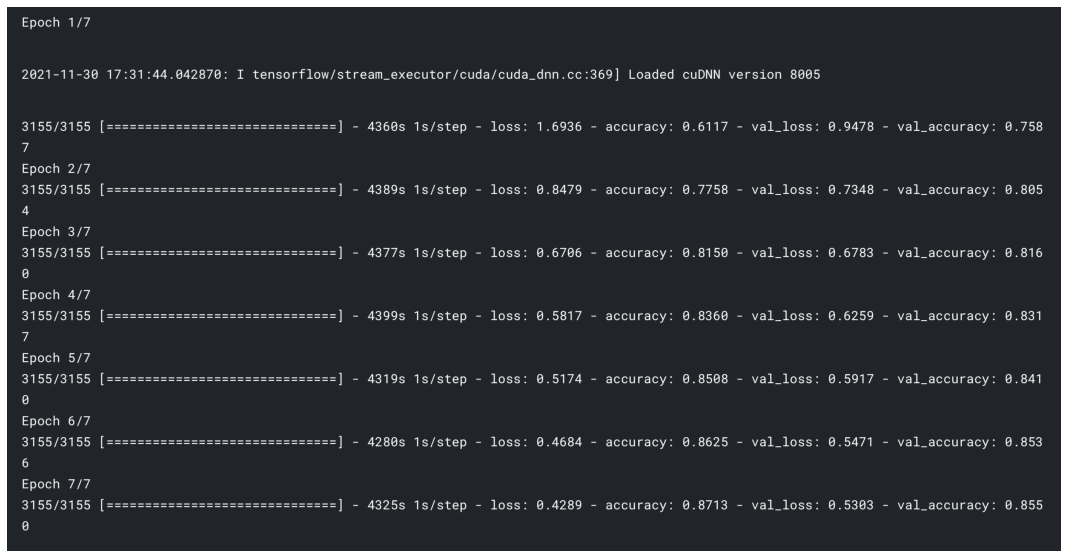

In [ ]:
img = Image.open('../input/markdownimages/Loss_accuracy.png')
plt.figure(figsize = (20,10))
plt.imshow(img)
plt.axis('off');

In [ ]:
# Another way to save model (never too careful)
model.save_weights("./model_weights_kld")
print("Saved model to disk")

# 4. Experiments

## 4.1 Evolution of loss and accuracy

In [ ]:
# Plot the accuracy and the loss according to the epochs

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

With the cell above we have obtained this kind of graph : 

![262149619_613409573411677_3902038137456021144_n.png](attachment:ba963073-895c-4a3b-876e-04ce62495200.png)

We can see that the model is not overfitting since the validation accuracy is increasing at the same time thant the training accuracy.
We also see that the model could continue to learn if we did more epochs, unfortunately the time being limited to 9 hours and that in the rules we could not take back our model to train it again we could not reach the moment where the model is optimal.

## 4.2 Confusion Matrix

In order to find the least well classified classes by the network we decided to compute the confusion matrix, but the data set being strongly unbalanced, to realize the real differences it is better to compute the normalized confusion matrix as it can be seen above.

In [ ]:
d = iter(validation_generator)
y_true = []
y_pred = []
i=0
mon_iter = iter(validation_generator)
#while i < 700:
while i < 30:
    d = mon_iter[i]
    i+=1
    y_true+=np.argmax(d[1],axis = 1).tolist()
    data = d[0]
    res = model.predict(data)
    y_pred+=np.argmax(model.predict(data),axis = 1).tolist()

y_t = np.array(y_true).flatten()
y_p = np.array(y_pred).flatten()

#Confusion Matrix
con_mat = tf.math.confusion_matrix(labels=y_t, predictions=y_p).numpy()

#Normalized Confusion Matrix
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

In [ ]:
plt.figure(figsize = (20,8))
plt.subplot(121)
ax = sns.heatmap(con_mat)
plt.title('Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('Ground Truth')
plt.subplot(122)
ax = sns.heatmap(con_mat_norm)
plt.title('Normalized Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('Ground Truth')
plt.show()

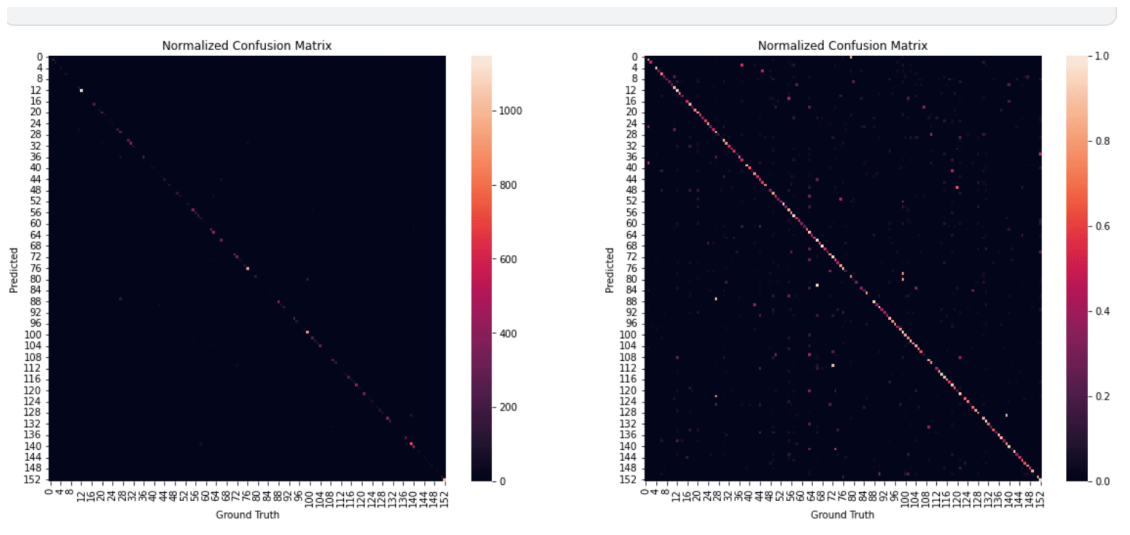

In [ ]:
img = Image.open('../input/markdownimages/matrix.png')
plt.figure(figsize = (20,10))
plt.imshow(img)
plt.axis('off');

On the confusion matrix (this one was computed with an old model), we can see that the diagonal is dominant which is a good news because this means that the good class is often predicted. However some classes like the 63 is often bad classified

One of our idea to operate this matrix was to set the weigths of the loss regarding the diagonal of the normed confusion matrix.
If a class is well classified, a lot of exemple will be on the diagonal so this value will be close to one,
on the other hand if a class is difficult to find the value will be small.
We consider that a class is difficult to predict if the value in the diagonal is less than 0.5 and easy to predict if the value is above 0.9

In [ ]:
#SEE 5.2.2 for more explenation

# extract diagonal
diag = np.diag(con_mat_norm)

# search for well/ bad classified class
to_augm = np.where(diag<0.5)[0]
tu_dim = np.where(diag>0.9)[0]

# set weights
weights = 0.05 * np.ones(153)
weights[to_augm] = 0.5
weights[to_dim] = 0.03

## 4.3 Test 

In [ ]:
chemin_test = '../input/polytech-nice-data-science-course-2021/polytech/test'

# new generator for the test set in anticipation of tta
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.4,
        vertical_flip=True,
        horizontal_flip=True,
        rescale=1./255,
        validation_split=0.2
    )

train_generator = train_datagen.flow_from_directory(
        directory=chemin_test,
        target_size=(height, width),
        batch_size=batch_size,
        color_mode = 'rgb',
        class_mode = 'categorical',
        subset = "training"
    )

After several experiment we found that doing test time augmentation was improving our results for 3 to 4%.
In order to do that we define 6 differents augementation to apply to the different images. Then we do the average over the probability and we select the argmax as one would normally do.

In [ ]:
chemin = '../input/polytech-nice-data-science-course-2021/polytech/test'

FichList = [ f for f in os.listdir(chemin) if os.path.isfile(os.path.join(chemin,f)) ]
Classes = []

tta = 6 # number of different augmentation to perform

# list of augmentations
D = [{},{'flip_horizontal': True,
          'flip_vertical': True,
         'shear':0.3,
         'theta':360},
         {'flip_horizontal': False,
          'flip_vertical': False,
         'shear':0.5,
         'theta':10},
         {'flip_horizontal': True,
          'flip_vertical': False,
         'zx':0.8,
         'zy':0.8},
         {'flip_horizontal': False,
          'flip_vertical': True,
         'shear':0.3,
         'theta':360},
         {'flip_horizontal': True,
          'flip_vertical': True,
         'zx':0.8,
         'zy':0.8},
        ]

etape = 0 # check in load if everything is going fine
for f in FichList:
    etape +=1
    im = plt.imread(chemin + '/'+ f)/255
    
    pred_tta = np.zeros((tta,153))
    
    for i in range(tta):
        it = train_datagen.apply_transform(im, D[i])
        it = resize(it, (height, width, 3))
        it = np.reshape(it, (-1,height, width, 3))
        pred_tta[i,:] = model.predict([it])
        
    if etape %1000 == 0:
        print(etape)
        
    pred_moy = np.mean(pred_tta,axis = 0)
    
    pred = np.argmax(pred_moy)
    print(f,pred)
    Classes.append(pred+1)

In [ ]:
d = pd.DataFrame()
d['image_name'] = np.array(FichList)
d['class'] = np.array(Classes)
print("Predictions finished")

In [ ]:
true_classes = np.arange(1,154,1)
df = pd.DataFrame(data = true_classes, columns = ['true_classes_int'])
true_class_string = [str(i) for i in true_classes]
df['true_classes_string'] = true_class_string
df_sorted = df.sort_values(by = ['true_classes_string'])
df_sorted['class_dataset'] = np.arange(0,153)
tcs = df_sorted.true_classes_string.to_numpy()
bd_finale = pd.DataFrame(tcs, columns =['true_classe'])
bd_finale.head()
n,m = d.shape
T = []
for i in range(n):
    false_c = int(d.iloc[i,1])-1
    true_c = bd_finale.iloc[false_c, 0]
    T.append(true_c)
    
d['class']=T

d.to_csv('./sample_submission_kld_tta.csv', index = False)

# 5. Progress

## 5.1 First trials

First we decided to test our model on a little CNN 




Our result were bad on the test set so we decided to choose pretrained model. 
In reality our model may not have been so bad because we hadn't yet seen that we didn't just have to add 1 to the label to get the right label. We realized that we didn't have the good labels for the testing set when we tested a vgg. Indeed on the validation set we reached at least 40% of accuracy, wherease on the test set we had less that 1% (Approximatively 1 week after the start). At this moment all the group was working with Pytorch.


## 5.2 Pre trained models


After that we decided to test different pretrained models.
Our best ones were efficient_net_b0 (experience done in Pytorch) and inception_resnet_v2 (experience done in Tensorflow)

### 5.2.1 Freeze or not 

One of our first idea was to **freeze** the model loaded with imagenet weights except the last layers. We wanted to do that because it accelerate the training. At first sight we though that it was a good idea beacause the model is trained on images from 1000 categories.

We decided to try to train the model with no freezing and with less epochs we obtained better results (we gain almost 10% when the model is not freezed).

### 5.2.2 Weighted loss

Since the data set is unbalanced, we wanted to try weighted loss.

The first idea was to give more weight to class that are less represented.

The second idea was to do a few number of epochs (1 or 2), then computing the confusion matrix, and counting the number of misclassified example per category. After that we increase (decrease) the weight of the class with a lot (few) number of misclassified images.

### 5.2.3 Loss

We start with the classical loss for multiclassification problem : The negative log likelihood loss
After several experiment we decided to test our training with another loss :
This loss is based on the probability distribution, good fact our activation function gives us a probability distribution
so our problem is suitable to KL divergence since Softmax “normalizes data into a probability distribution consisting of 153 probabilities proportional to the exponentials of the input numbers” (Wikipedia, 2006).
With this new loss we observe an acceleration of our training and a better accuracy (2-3 percents).

### 5.2.4 Optimizer and Learning Rate

Our first optimizer was Adam (Adaptive moment estimation), the optimizer uses momentum and adaptative learning rate to converge faster. With this optimizer the learning rate is automatically decreased byt the algorithm.
When we tested the inception resnet we decided to use RMSProp since it was the optimizer use in their experiments, the results were similar with Adam optimizer so we decided to keep Adam, since it is more sophisticate than RMSProp.


## 5.3 Testing

At testing time we fed our model with images from the testing set without any augmentation (except resizing and normalization).
But we saw that we could do test time augmentation.
We chose 6 differents augmentation to apply to each image of the testing set.
As said above this technique allowed us to improve our results by 3-4%.

# 5.4 Combining predictions

We merged our 5 best submissions on the leaderboard on an excel spreadsheet which we used to find for each image wich class was appearing the most (MODE.SIMPLE) if 2 classes were tied or all classes were different we chose to keep the class from the best submission. With this trick we gain almost 2%.

# 6. Conclusion 

Thanks to this project, we were able to put into practice the numerous data science tools seen in the courses and practical work such as pre-processing with the study of the data or the choice of the model. The fact that this project was a competition motivated us to improve our result each time or to look for another better model.

Moreover we developped new skills in Tensorflow and Pytorch. We were able to see the advantages and disadvantages of each. For example in TensorFlow there is no need to code the training function ourselves. On the other hand, the fact to be able to create very easily custom datasets in pytorch is a strong point for this library.

To improve our result, with more resources we could have trained GAN for classes with few images in order to solve the fact that the dataset is unbalanced. If it was allowed we could have trained our model with more epochs. 

# Sources

 [Adam Optimizer](https://towardsdatascience.com/adam-optimization-algorithm-1cdc9b12724a)
 
 [Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning](https://arxiv.org/abs/1602.07261v2)
 
 [Wikipedia KLD](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence)
 
 [Pytorch KLD](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html)
 
 [Tensorflow KLD](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/kl_divergence)
 
 [Efficient net Paper](https://arxiv.org/pdf/1905.11946.pdf)
 
 [Momentum and Lr](https://cnl.salk.edu/~schraudo/teach/NNcourse/momrate.html)
 
 [A Complete Guide to Adam and RMSprop Optimizer](https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be)

# Overview of the work in Pytorch

In this section you can find the main steps of our work in Pytorch
The notebook can be found [here](https://www.kaggle.com/julietores/notebookfinal?scriptVersionId=81122696)

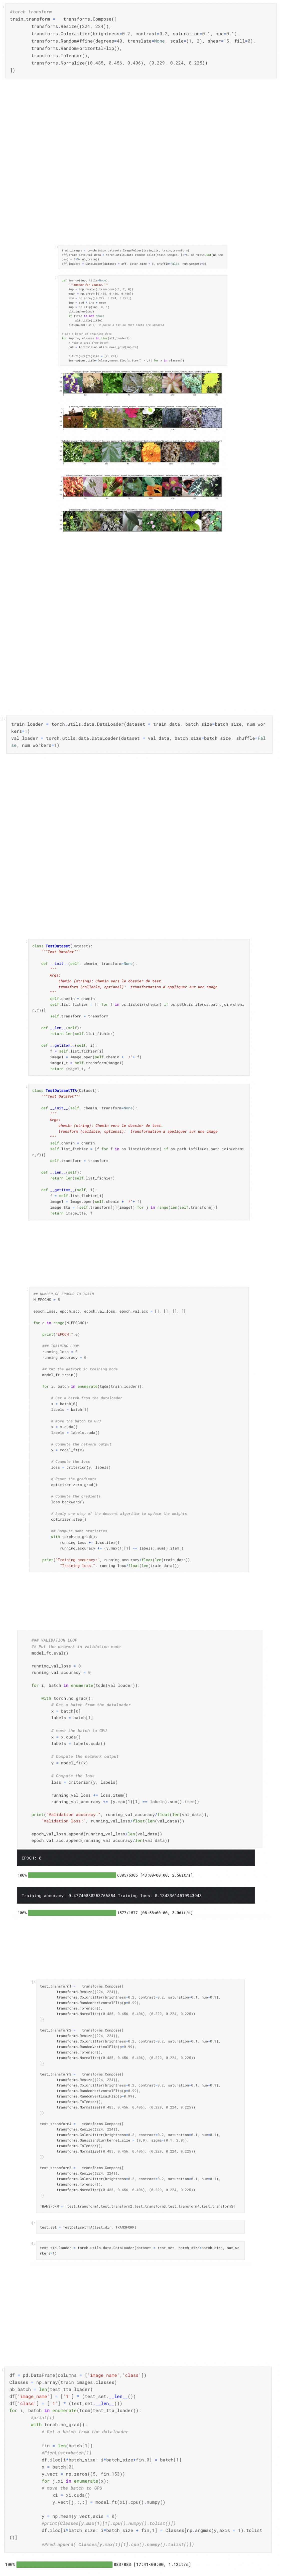

In [ ]:
img1 = Image.open('../input/markdownimages/TorchTrensform.png')
img2 = Image.open('../input/markdownimages/TorchDisplay.png')
img3 = Image.open('../input/markdownimages/TorchLoader.png')
img4 = Image.open('../input/markdownimages/TorchTestCustomClass.png')
img5 = Image.open('../input/markdownimages/TorchTrainingP1.png')
img6 = Image.open('../input/markdownimages/TorchTrainingP2.png')
img7 = Image.open('../input/markdownimages/TorchTestLoader.png')
img8 = Image.open('../input/markdownimages/TorchTTA.png')
plt.figure(figsize = (20,200))
plt.subplot(811)
plt.imshow(img1)
plt.axis('off')
plt.subplot(812)
plt.imshow(img2)
plt.axis('off')
plt.subplot(813)
plt.imshow(img3)
plt.axis('off')
plt.subplot(814)
plt.imshow(img4)
plt.axis('off')
plt.subplot(815)
plt.imshow(img5)
plt.axis('off')
plt.subplot(816)
plt.imshow(img6)
plt.axis('off')
plt.subplot(817)
plt.imshow(img7)
plt.axis('off')
plt.subplot(818)
plt.imshow(img8)
plt.axis('off');